Beginning of our exploration of MTA data. 

In [1]:
api_key = "a57e16aadfd85e7b920ed17db1a0e751"

### Import Statements

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import re

Data import statements: uncomment when running this code locally. 

In [3]:
# df_entrances = pd.read_csv("http://web.mta.info/developers/data/nyct/subway/StationEntrances.csv")
df_j3 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170603.txt")

In [4]:
#save locally
# df_entrances.to_csv('entrances.csv')
df_j3.to_csv('turnstyle_jun_3.csv')

In [5]:
#import locally
# de_entrances = pd.read_csv('entrances.csv')
df_j3 = pd.read_csv('turnstyle_jun_3.csv')

### Turnstyles Data

Downloading the turnstyle data for June 3. Need a naming convention. df_j3 will henceforth be known as the turnstyle data for june 3. We can assume it is turnstyle data since there is nothing else that will be reported by week. 

In [6]:
df_j3.sample(10)[:3]

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
9604,9604,A054,R227,01-03-00,RECTOR ST,NRW,BMT,06/01/2017,08:00:00,REGULAR,3336036,1246358
19907,19907,C008,R099,00-03-04,DEKALB AV,BDNQR,BMT,05/30/2017,00:00:00,REGULAR,4704423,2185555
176210,176210,R514,R094,00-00-03,ASTORIA BLVD,NQW,BMT,06/02/2017,12:00:00,REGULAR,11961898,858177


I am going to have to make these letters lowercase and remove any excess white space. 

In [7]:
df_j3.columns = df_j3.columns.str.strip().str.lower()
print(df_j3.columns)

Index(['unnamed: 0', 'c/a', 'unit', 'scp', 'station', 'linename', 'division',
       'date', 'time', 'desc', 'entries', 'exits'],
      dtype='object')


In [8]:
len(df_j3['station'].unique())

374

In [9]:
test = df_j3
test.head(3)

,unnamed: 0,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,00:00:00,REGULAR,6195217,2098317
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,04:00:00,REGULAR,6195240,2098318
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,08:00:00,REGULAR,6195256,2098347


This section is an attempt to get subtotals for the individual sensors, c/a (though I have later found out that these are not the individual devices. We are going through the data set and taking the starting and ending observations for each sensor (c/a) and saving it as a variable. 

In [10]:
s = abs(test.sort_values(by=['station','linename','scp','date'])['entries'].diff())

In [11]:
s.value_counts().head()

0.0    31408
1.0     3360
2.0     2399
3.0     2021
4.0     1864
Name: entries, dtype: int64

In [12]:
s.std()

58405566.461769685

Ok, I am going to test different grouping and sorting techniques, put each one in a data set, and do some descripitive statistics on the resultling 'hourly' variable. The default for pandas sort is False.

In [13]:
#sort
test_sorted = s
test_sorted['hourly'] = abs(test.sort_values(by=['station','linename','scp','date','time'])['entries'].diff())

In [14]:
print(len(test_sorted))
print(len(test))

195959
195958


In [15]:
std_3 = test_sorted['hourly'].std()

In [16]:
print(std_3)

112116234.289


In [17]:
#create a new df in which we create the test id
test_id = test

In [18]:
test_id['id'] = test_id['station'] + test_id['linename'] + test_id['scp']

In [19]:
test_id['hourly'] = abs(test_id.sort_values(by=['id','date','time'])['entries'].diff())

In [20]:
std_4 = test_id['hourly'].std()

In [21]:
std_4/std_3

1.0004703115265443

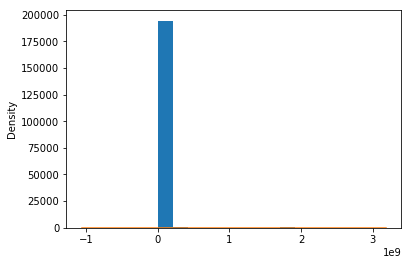

In [22]:
test_id['hourly'].hist()
test_id['hourly'].plot(kind='kde')

I am going to try to loop through the unique ids we made and calculate the differences within those id groups. 

In [23]:
len(test_id['id'].unique())

4571

In [24]:
# for i in test_id['id']:
#     print(i)

In [25]:
test_id.head()

,unnamed: 0,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,id,hourly
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,00:00:00,REGULAR,6195217,2098317,59 STNQR456W02-00-00,5992912.0
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,04:00:00,REGULAR,6195240,2098318,59 STNQR456W02-00-00,23.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,08:00:00,REGULAR,6195256,2098347,59 STNQR456W02-00-00,16.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,12:00:00,REGULAR,6195346,2098432,59 STNQR456W02-00-00,90.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,16:00:00,REGULAR,6195518,2098491,59 STNQR456W02-00-00,172.0


### Older Plan

std_1 is the standard deviation from sorting by ['station','scp','date','time'] and taking the difference between entries. Nine digit standard deviations indicate a bad number. When we add 'linename' to the sorting terms we get a reduction in the standard deviation of about 81 million, so that is something.   

Next I take the absolute value of the difference to try to cancel out the noise of the units that count backwards. That doesn't really make much difference. But now we can look at dividing the standard deviations and seeing what that does and we see that the standard deviations improve by about half when we bring the 'linename' into the sort.  

Now I am going to try Jonathan's idea of creating a unique id by adding togehter the variables we think are important. Now the interesting thing is that the performance of the model seems to have actually gotten worse. The standard deviation of the model when we take the data sorted by the new id and then sorted by time is just a little over half the size of the original standard deviation. This is after taking the absolute value of the differences. So this is really terrible. The hourly entries are still coming out measured on a scale that reaches into the billions. This data is close to totally useless.  

There are going to be two sources of rediculous values, resets and different machines. To get any kind of reasonable estimates we have to get rid of the differences caused by different machines. We should make a list of the unique ids, loop through that list running diff on all the members in that list to populate 'hourly', and then go on to the next id in the list. Resets that happen within that group will still be a problem but those we might be able to deal with as missing data and just get rid of them. 

Joe says they just chose 20k as a cut-off and went from there. They found a kde plot that gave them a sort of reasonable argument for choosing that level as a cutoff. I am tempted to go with that.  

Now I need to review the commands for getting rid of data. I have to just throw out some data so that we can move on to other parts of the analysis. Once we get a reasonable analysis we can get a minimal acceptable product up and go back and make refinements if we like.  

So, the first thing is to go through the data set and have a criteria for making out things as NaN. A bit of an internet search is necessary.  



### New Plan
Talked to David and he expressed confidence that the whole problem could be handled by groupby. In particular, he said that all the trouble we went through with ids could be handled by `.groupby()` and `.diff()`.  

This is his **claim**: the diff funciton called on a group will return the values for the differences in the rows that are in that group, not the differences between the groups. I find this hard to believe, but he is the expert and I have to give it a try. 

The test data set still has the hourly and id variables attached but I don't see any need to get rid of them. I can keep them and create the new versions of hourly to compare, even.  

In [26]:
test_diff = test.groupby(['station','linename','scp'])['entries'].diff()

In [27]:
print(len(test_diff))
print(len(test))

195958
195958


My God! I didn't believe him, but he is right. So now we have a diff for each of the entries of hourly and it seems like we should be able to just tack it back on the data set. I have to get the thing working now.  

First I will get the standard deviation and compare it to standard deviation 3, which was the best I had done so far. 

In [28]:
std_diff = test_diff.std()
print(std_diff)
print(std_diff/std_3)

11796568.8969
0.105217312834


Ok, so this is a huget improvement, though you wouldn't know it from the absolute value of the standard deviation. That is about 1/20 the first standard deviation I had obtained.  

Lets look at a histogram. 

In [29]:
test_diff.describe()

count    1.913870e+05
mean     6.163596e+04
std      1.179657e+07
min     -1.821377e+09
25%      8.000000e+00
50%      6.700000e+01
75%      2.230000e+02
max      1.948041e+09
Name: entries, dtype: float64

In [30]:
6.163596e+04

61635.96

An average value of 61,000 is still insane but at least in the realm of human experience. 

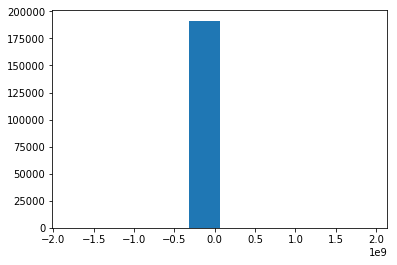

In [31]:
plt.hist(test_diff.dropna());

But the histogram is still on a scale of billions. That is rediculous. What can we do? What about sorting by date and time? What that done? The date time sort would have to be done after the groupby operation for it to have effect, no? 

In [32]:
test_diff_sorted = test.sort_values(['date','time'], ascending=True).groupby(['station','linename','scp'])['entries'].diff()

In [33]:
len(test_diff_sorted)

195958

In [34]:
test_diff_sorted.describe()

count    1.913870e+05
mean     9.999670e+03
std      1.058642e+08
min     -1.948056e+09
25%      6.000000e+00
50%      6.600000e+01
75%      2.330000e+02
max      1.948057e+09
Name: entries, dtype: float64

In [35]:
9.999670e+03

9999.67

In [36]:
test.head()

,unnamed: 0,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,id,hourly
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,00:00:00,REGULAR,6195217,2098317,59 STNQR456W02-00-00,5992912.0
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,04:00:00,REGULAR,6195240,2098318,59 STNQR456W02-00-00,23.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,08:00:00,REGULAR,6195256,2098347,59 STNQR456W02-00-00,16.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,12:00:00,REGULAR,6195346,2098432,59 STNQR456W02-00-00,90.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,16:00:00,REGULAR,6195518,2098491,59 STNQR456W02-00-00,172.0


(array([  1.23000000e+02,   4.10000000e+01,   4.20000000e+01,
          4.20000000e+01,   4.10000000e+01,   4.20000000e+01,
          0.00000000e+00,   4.10000000e+01,   4.10000000e+01,
          8.30000000e+01,   0.00000000e+00,   4.20000000e+01,
          1.67000000e+02,   8.40000000e+01,   1.65498000e+05,
          2.43510000e+04,   8.40000000e+01,   1.24000000e+02,
          4.30000000e+01,   0.00000000e+00,   8.30000000e+01,
          4.20000000e+01,   4.20000000e+01,   0.00000000e+00,
          4.10000000e+01,   0.00000000e+00,   4.10000000e+01,
          4.30000000e+01,   8.40000000e+01,   1.22000000e+02]),
 array([ -1.94805603e+09,  -1.81818560e+09,  -1.68831517e+09,
         -1.55844474e+09,  -1.42857431e+09,  -1.29870388e+09,
         -1.16883345e+09,  -1.03896302e+09,  -9.09092587e+08,
         -7.79222157e+08,  -6.49351727e+08,  -5.19481297e+08,
         -3.89610867e+08,  -2.59740437e+08,  -1.29870007e+08,
          4.23000000e+02,   1.29870853e+08,   2.59741283e+08,
      

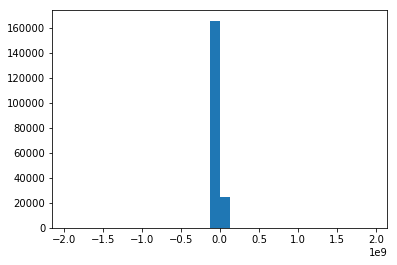

In [37]:
plt.hist(test_diff_sorted.dropna(), bins=30)

In [38]:
len(test.scp.unique())

230

Since there are more units than there are scps maybe we should throw them into the grouping mix, too. 

In [39]:
test_diff_sorted_units = test.sort_values(['date','time'], ascending=True).groupby(['station','linename','unit','scp'])['entries'].diff()

In [40]:
len(test_diff_sorted_units)
test_diff_sorted_units.describe()

count    1.912700e+05
mean     2.150756e+03
std      5.708554e+05
min     -4.470296e+06
25%      8.000000e+00
50%      6.700000e+01
75%      2.230000e+02
max      1.979471e+08
Name: entries, dtype: float64

In [41]:
2.150756e+03

2150.756

In [42]:
test_diff_sorted_units.isnull().value_counts()

False    191270
True       4688
Name: entries, dtype: int64

So this is the best the data set has ever been but I am still not sure that it is meaningful. What is this thing doing? 

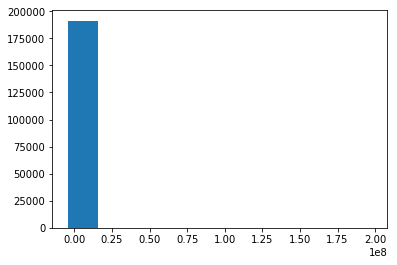

In [43]:
plt.hist(test_diff_sorted_units.dropna());

I have to find a way to get rid of the reset caused problems. I want to go through and assign the value of missing (nan) to any data point where the value is zero and the value preceeding it is greater than 10,000.  

Also, I want to compare the effects of sorting with units before scps or scps before units or leaving one or the other out.  

Finally, I want to think about my assumption that large values or large standard deviations are an infallible indicator of bad data.  

In [44]:
# testing = test.groupby(['station','linename','scp','unit'])apply(lambda x: \
#                                                              x.sort_values(['date','time'])).diff()

In [45]:
testing = test.groupby(['station','linename','scp','unit'])['entries'].diff()

In [46]:
testing2 = abs(testing)

In [47]:
testing2[testing2 >3000] = np.nan

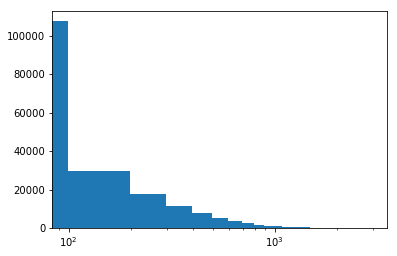

In [48]:
plt.xscale('log')
plt.hist(testing2.dropna(), bins=30);

In [49]:
print(testing2[testing2>2500])

4743      2630.0
46237     2822.0
151010    2608.0
151016    2776.0
151046    2769.0
151052    2622.0
151130    2854.0
151136    2564.0
151142    2678.0
152055    2523.0
152085    2861.0
152091    2965.0
152097    2769.0
157156    2697.0
157207    2729.0
175952    2508.0
Name: entries, dtype: float64


In [50]:
print(len(testing2))
print(len(test))

195958
195958


In [51]:
test['hourly'] = testing2

In [52]:
test.head()

,unnamed: 0,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,id,hourly
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,00:00:00,REGULAR,6195217,2098317,59 STNQR456W02-00-00,NaN
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,04:00:00,REGULAR,6195240,2098318,59 STNQR456W02-00-00,23.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,08:00:00,REGULAR,6195256,2098347,59 STNQR456W02-00-00,16.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,12:00:00,REGULAR,6195346,2098432,59 STNQR456W02-00-00,90.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,16:00:00,REGULAR,6195518,2098491,59 STNQR456W02-00-00,172.0


In [53]:
test

,unnamed: 0,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,id,hourly
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,00:00:00,REGULAR,6195217,2098317,59 STNQR456W02-00-00,NaN
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,04:00:00,REGULAR,6195240,2098318,59 STNQR456W02-00-00,23.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,08:00:00,REGULAR,6195256,2098347,59 STNQR456W02-00-00,16.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,12:00:00,REGULAR,6195346,2098432,59 STNQR456W02-00-00,90.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,16:00:00,REGULAR,6195518,2098491,59 STNQR456W02-00-00,172.0
5,5,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,20:00:00,REGULAR,6195765,2098537,59 STNQR456W02-00-00,247.0
6,6,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/28/2017,00:00:00,REGULAR,6195898,2098559,59 STNQR456W02-00-00,133.0
7,7,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/28/2017,04:00:00,REGULAR,6195914,2098562,59 STNQR456W02-00-00,16.0
8,8,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/28/2017,08:00:00,REGULAR,6195930,2098581,59 STNQR456W02-00-00,16.0
9,9,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/28/2017,12:00:00,REGULAR,6196024,2098646,59 STNQR456W02-00-00,94.0


In [54]:
final_test_column_names = ['0', 'c/a', 'unit', 'scp', 'station_name']

In [55]:
test_columns_to_append = test.columns[5:]

In [56]:
for i in test_columns_to_append:
    
    final_test_column_names.append(i)

In [57]:
test.columns = final_test_column_names

In [58]:
test2 = test[test['hourly'] < 3000]

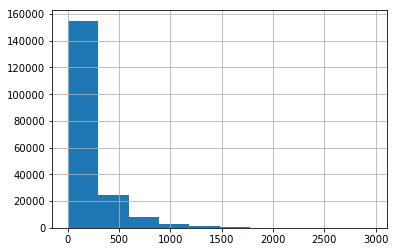

In [59]:
test2.hourly.hist()

In [60]:
merged_descriptives = pd.read_csv('merged_locations_demographics_df.csv')

In [61]:
merged_descriptives.head()

,Unnamed: 0,station_name,geocode_result,latitude,longitude,zip_code,COUNT PARTICIPANTS,COUNT FEMALE,PERCENT FEMALE,COUNT MALE,...,PERCENT PUBLIC ASSISTANCE TOTAL,neighborhood,Avg_Price,Median_Price,Price_Sq_Ft_Avg,Avg_Sq_Ft,Mean_Price,Med_Price,Avg_Price_Sq_Ft,Mean_Sq_Ft
0,0,59 ST,[{'address_components': [{'long_name': 'Columb...,40.768780,-73.982115,10023,7.0,5.0,0.71,2.0,...,100.0,Upper West Side,"$1,892,474","$1,050,000","$1,701","1,112",1892474.0,1050000.0,1701.0,1112.0
1,1,5 AV/59 ST,"[{'address_components': [{'long_name': '1-5', ...",40.765239,-73.974720,10022,1.0,1.0,1.00,0.0,...,100.0,Midtown East,"$2,992,673","$1,250,000","$2,348","1,274",2992673.0,1250000.0,2348.0,1274.0
2,2,57 ST-7 AV,[{'address_components': [{'long_name': 'New Yo...,40.765531,-73.980303,10106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,49 ST,[{'address_components': [{'long_name': 'United...,40.760374,-73.983548,10020,0.0,0.0,0.00,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,TIMES SQ-42 ST,[{'address_components': [{'long_name': 'New Yo...,40.755222,-73.987402,10018,3.0,2.0,0.67,1.0,...,100.0,Midtown West,"$1,756,384","$950,000","$1,338","1,312",1756384.0,950000.0,1338.0,1312.0


In [62]:
final_merged_data_with_descriptives = pd.merge(test2, merged_descriptives, how = 'left', on = 'station_name')

In [63]:
final_merged_data_with_descriptives.head()

,0,c/a,unit,scp,station_name,linename,division,date,time,desc,...,PERCENT PUBLIC ASSISTANCE TOTAL,neighborhood,Avg_Price,Median_Price,Price_Sq_Ft_Avg,Avg_Sq_Ft,Mean_Price,Med_Price,Avg_Price_Sq_Ft,Mean_Sq_Ft
0,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,04:00:00,REGULAR,...,100.0,Upper West Side,"$1,892,474","$1,050,000","$1,701","1,112",1892474.0,1050000.0,1701.0,1112.0
1,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,08:00:00,REGULAR,...,100.0,Upper West Side,"$1,892,474","$1,050,000","$1,701","1,112",1892474.0,1050000.0,1701.0,1112.0
2,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,12:00:00,REGULAR,...,100.0,Upper West Side,"$1,892,474","$1,050,000","$1,701","1,112",1892474.0,1050000.0,1701.0,1112.0
3,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,16:00:00,REGULAR,...,100.0,Upper West Side,"$1,892,474","$1,050,000","$1,701","1,112",1892474.0,1050000.0,1701.0,1112.0
4,5,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,20:00:00,REGULAR,...,100.0,Upper West Side,"$1,892,474","$1,050,000","$1,701","1,112",1892474.0,1050000.0,1701.0,1112.0


In [64]:
house_price_median = final_merged_data_with_descriptives.Mean_Price.median()

In [65]:
'''
These are the stations in the zip codes with mean house prices greater than the median
'''

top_house_price_df = final_merged_data_with_descriptives[(final_merged_data_with_descriptives['Mean_Price'] > house_price_median)]

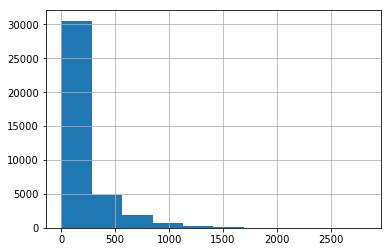

In [66]:
top_house_price_df.hourly.hist()

In [67]:
'''
These are the stations in the zip codes with larger female populations
'''

med_female_pop = final_merged_data_with_descriptives['PERCENT FEMALE'].median()

top_female_pop_df = final_merged_data_with_descriptives[final_merged_data_with_descriptives['PERCENT FEMALE'] > med_female_pop]

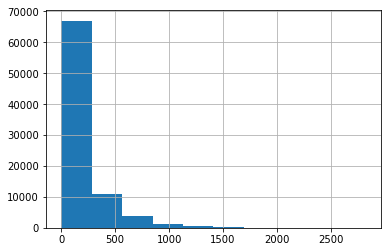

In [68]:
top_female_pop_df.hourly.hist()

In [69]:
top_female_pop_top_housing_prices_df = final_merged_data_with_descriptives[(final_merged_data_with_descriptives['PERCENT FEMALE'] > med_female_pop) & (final_merged_data_with_descriptives['Mean_Price'] > house_price_median)]

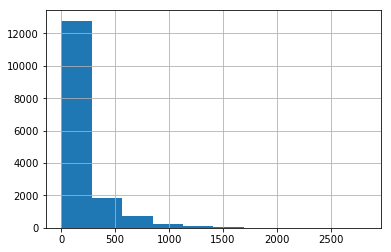

In [70]:
top_female_pop_top_housing_prices_df.hourly.hist()

In [79]:
def map_stations(df, size = 1):
    
    %matplotlib inline
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap

    # New York Central Park
    # Longitude: -73.968285
    # Latitude: 40.785091


    lower_left = (40.5795, -74.1502)

    upper_right = (40.85, -73.8667)

    m = Basemap(projection='merc',llcrnrlat=lower_left[0],urcrnrlat=upper_right[0],\
                llcrnrlon=lower_left[1], urcrnrlon=upper_right[1], resolution='h', area_thresh=50, lat_0=40.78, lon_0=-73.96)

    m.drawmapboundary()
    m.drawcoastlines(color='black', linewidth=0.4)
    m.drawrivers(color='blue')
    m.fillcontinents(color='lightgray')

    lons = df['longitude'].values
    lats = df['latitude'].values
    names = df['station_name'].values


    x,y = m(lons, lats)

    # r = red; o = circle marker (see: http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot)

    m.plot(x, y, 'ro', markersize = size )
    
    if len(x) < 11:
        
        for name, x, y in zip(names, x, y):
            plt.annotate(
                name,
                xy=(x, y), xytext=(-20, 20),
                textcoords='offset points', ha='right', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


    plt.figure(figsize=(20,10))

    plt.show()


In [94]:
def get_loc_data(df):
    
    return pd.merge(df, merged_descriptives, how = 'left', on = 'station_name')
    

In [120]:
top_fem_pop_top_house_price_entries_agg = top_female_pop_top_housing_prices_df.groupby(['station_name'])['hourly'].mean()

In [129]:
top_10_houses_top_10_fem_pop = pd.DataFrame(top_female_pop_top_housing_prices_df.groupby(['station_name'])['hourly'].mean()[:10].reset_index().sort_values(by = 'hourly',ascending = False))

/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more deta

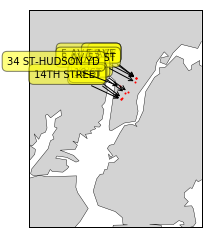

In [133]:
map_stations(get_loc_data(top_10_houses_top_10_fem_pop))

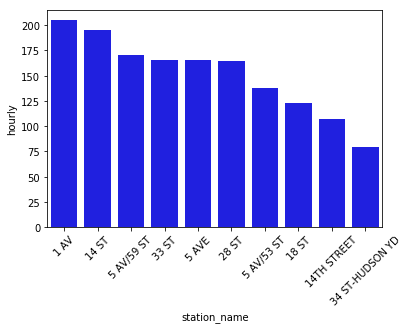

In [131]:
top_10_houses_top_10_fem_pop_bar  = sns.barplot(x = 'station_name', 
                y ='hourly', 
                data = top_10_houses_top_10_fem_pop, color = 'blue')

plt.xticks(rotation=45)
plt.show()


/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more deta

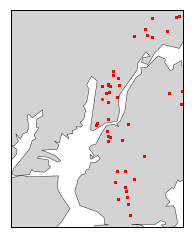

In [99]:
map_stations(top_female_pop_df)

In [154]:
highest_hourly = pd.DataFrame(final_merged_data_with_descriptives.groupby('station_name')['hourly'].mean().sort_values(ascending=False))[:10]

In [155]:
top_10 = highest_hourly[:10]

In [162]:
top_10_dict = {}

for i in top_10.index:
    top_10_dict[i] = True

In [163]:
top_10_dict

{'103 ST-CORONA': True,
 '14 ST-UNION SQ': True,
 '57 ST-7 AV': True,
 'FLUSHING-MAIN': True,
 'GATES AV': True,
 'JKSN HT-ROOSVLT': True,
 'MYRTLE AV': True,
 'NOSTRAND AV': True,
 'QUEENSBORO PLZ': True,
 'YORK ST': True}

In [166]:
merged_descriptives['top_10'] = merged_descriptives['station_name'].map(top_10_dict)

In [172]:
top_10_station_locs = merged_descriptives[merged_descriptives['top_10'] == True]

/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more deta

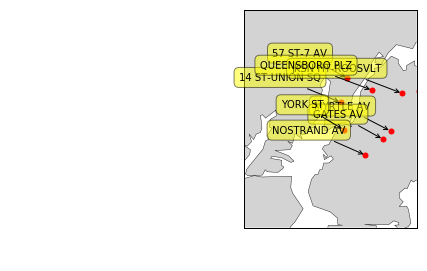

In [186]:
map_stations(top_10_station_locs, 5)

In [76]:
for i in final_merged_data_with_descriptives.columns:
    
    print(i)

0
c/a
unit
scp
station_name
linename
division
date
time
desc
entries
exits
id
hourly
Unnamed: 0
geocode_result
latitude
longitude
zip_code
COUNT PARTICIPANTS
COUNT FEMALE
PERCENT FEMALE
COUNT MALE
PERCENT MALE
COUNT GENDER UNKNOWN
PERCENT GENDER UNKNOWN
COUNT GENDER TOTAL
PERCENT GENDER TOTAL
COUNT PACIFIC ISLANDER
PERCENT PACIFIC ISLANDER
COUNT HISPANIC LATINO
PERCENT HISPANIC LATINO
COUNT AMERICAN INDIAN
PERCENT AMERICAN INDIAN
COUNT ASIAN NON HISPANIC
PERCENT ASIAN NON HISPANIC
COUNT WHITE NON HISPANIC
PERCENT WHITE NON HISPANIC
COUNT BLACK NON HISPANIC
PERCENT BLACK NON HISPANIC
COUNT OTHER ETHNICITY
PERCENT OTHER ETHNICITY
COUNT ETHNICITY UNKNOWN
PERCENT ETHNICITY UNKNOWN
COUNT ETHNICITY TOTAL
PERCENT ETHNICITY TOTAL
COUNT PERMANENT RESIDENT ALIEN
PERCENT PERMANENT RESIDENT ALIEN
COUNT US CITIZEN
PERCENT US CITIZEN
COUNT OTHER CITIZEN STATUS
PERCENT OTHER CITIZEN STATUS
COUNT CITIZEN STATUS UNKNOWN
PERCENT CITIZEN STATUS UNKNOWN
COUNT CITIZEN STATUS TOTAL
PERCENT CITIZEN STATUS TO

In [77]:
top_female_pop_df = final_merged_data_with_descriptives[(final_merged_data_with_descriptives['PERCENT FEMALE'] > med_female_pop)]

In [78]:
top_housing_prices_df = final_merged_data_with_descriptives[(final_merged_data_with_descriptives['Mean_Price'] > house_price_median)]

In [90]:
top_10_female_pop_df = pd.DataFrame(top_female_pop_df.groupby(['station_name'])['hourly'].mean().reset_index()).sort_values(by = 'hourly', ascending = False)[:10]

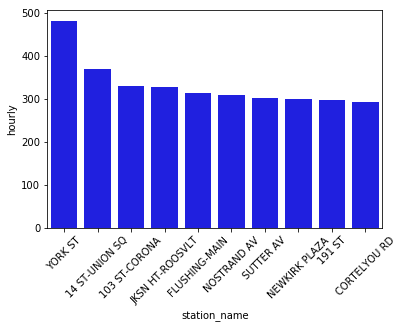

In [118]:
top_10_fem_pop_bar = sns.barplot(x = 'station_name', 
                y ='hourly', 
                data = top_10_female_pop_df, color = 'blue')

plt.xticks(rotation=45)
plt.show()

/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more deta

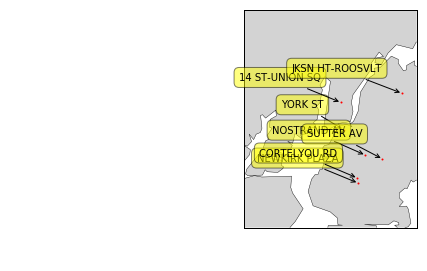

In [95]:
map_stations(get_loc_data(top_10_female_pop_df))

In [98]:
top_10_house_prices_df = pd.DataFrame(top_housing_prices_df.
                                      groupby(['station_name'])['hourly'].
                                      mean().
                                      reset_index()).sort_values(by = 'hourly', ascending = False)[:10]

/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/jonathanjramirez/anaconda/envs/py3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more deta

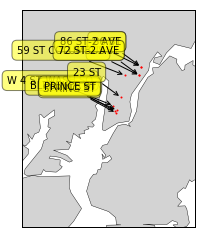

In [101]:
map_stations(get_loc_data(top_10_house_prices_df))

In [102]:
import seaborn as sns

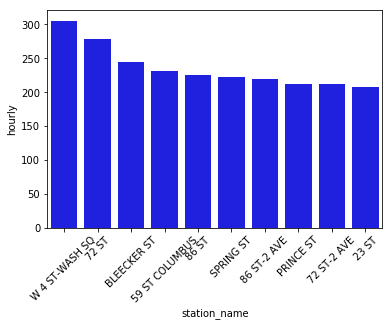

In [117]:
top_10_houses = sns.barplot(x = 'station_name', 
                y ='hourly', 
                data = top_10_house_prices_df, color = 'blue')

plt.xticks(rotation=45)
plt.show()